# Make of a neural network with numpy

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_6816/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Using ndarrays as Tensors, adding the typing library to be more explicit and creating a new type "Func" which is a function taking a Tensor as argument and returning a Tensor

In [2]:
from numpy import ndarray as Tensor

from typing import (Dict, Tuple, Callable, 
                    Sequence, Iterator, NamedTuple)
Func = Callable[[Tensor], Tensor]

### Defining the Loss function to minimize

In [3]:
class MeanSquareError:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return np.sum((predicted - actual)**2) / len(actual)
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return 2 * (predicted - actual) / len(actual)

### Constructring the different layers with classes

In [4]:
# Class constructing a generic layer

class Layer:
    def __init__(self) -> None:

        # Stocking the parameters values and gradients in dictionnaries
        self.params: Dict[str, Tensor] = {}
        self.grads: Dict[str, Tensor] = {}

    def forward(self, inputs: Tensor) -> Tensor:
        raise NotImplementedError

    def backward(self, grad: Tensor) -> Tensor:
        raise NotImplementedError


# Class constructing a linear layer of neurons

class Linear(Layer):
    """
    Inputs are of size (batch_size, input_size)
    Outputs are of size (batch_size, output_size)
    """
    def __init__(self, input_size: int, output_size: int) -> None:
    
        # Inherit from base class Layer
        super().__init__()
        
        # Initialize the weights and bias with random values
        self.params["w"] = np.random.randn(input_size, output_size)
        self.params["b"] = np.random.randn(output_size)

    def forward(self, inputs: Tensor) -> Tensor:
        """
        inputs shape is (batch_size, input_size)
        """
        self.inputs = inputs
        
        # Compute the feed forward pass
        """
        (b,i) @ (i,o) + (1,o) = (b,o)
        """
        return inputs @ self.params["w"] + self.params["b"]
        
     
        
    def backward(self, grad: Tensor) -> Tensor:
        """
        grad shape is (batch_size, output_size)
        """
        # Compute the gradient parameters for the layer
        self.grads["w"] =  np.transpose(self.inputs) @ grad
        """
        (i,b) @ (b,o) = (i,o)
        """
        self.grads["b"] = grad
        """
        (b,o) 
        """
        # Compute the feed backward pass
        """
        (b,o) @ (o,i) = (b,i)
        """
        return grad @ np.transpose(self.params["w"])


#Defining possible activation functions

def tanh(x: Tensor) -> Tensor:
    return np.tanh(x)

def tanh_prime(x: Tensor) -> Tensor:
    return 1 - (np.tanh(x))**2

def sigmoid(x: Tensor) -> Tensor:
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x: Tensor) -> Tensor:
    return sigmoid(x)*(1 - sigmoid(x))

def relu_prime(x: Tensor) -> Tensor:
    return np.where(x <= 0, 0, 1)

# Class constructing an activation layer

class Activation(Layer):
    """
    An activation layer just applies a function
    elementwise to its inputs
    """
    def __init__(self, f: Func, f_prime: Func) -> None:
        super().__init__()
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs: Tensor) -> Tensor:
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad: Tensor) -> Tensor:
        return self.f_prime(self.inputs) * grad

### Class constructing the network, doing the full forward and backward pass and optimizing the parameters

In [5]:
class NeuralNet:
    def __init__(self, layers: Sequence[Layer], lr: float = 0.01) -> None:
        self.layers = layers
        self.lr = lr 
        """
        Learning rate
        """
    def forward(self, inputs: Tensor) -> Tensor:
        """
        The forward pass takes the layers in order
        """
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad: Tensor) -> Tensor:
        """
        The backward pass is the other way around
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def optimize(self) -> None:
        """
        Optimize the paramaters value at each step
        """
        for layer in self.layers:
                for name in layer.params.keys():
                    layer.params[name] = layer.params[name] - self.lr * layer.grads[name]

### Defining the training routine of the network

In [6]:
def train(net: NeuralNet, inputs: Tensor, targets: Tensor,
          loss: MeanSquareError,
          num_epochs: int = 5000) -> None:
    Loss_list : Sequence = []
    Acc_list : Sequence = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        predicted = net.forward(inputs)
        epoch_loss = loss.loss(predicted, targets)
        epoch_grad = loss.grad(predicted, targets)
        net.backward(epoch_grad)
        net.optimize()
        
        epoch_acc = np.mean(np.round(predicted)==targets) * 100

        Loss_list.append(epoch_loss)
        Acc_list.append(epoch_acc)
            
        # Print status every 100 iterations
        if epoch % 100 == 0:
            print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)
    
    print("Targets - Predictions - Results")
    for y, z in zip(targets, predicted):
        print(f'{y} => {z} => {z.round()}')
    
    
    plt.plot(Acc_list)
    plt.ylabel('Accuracy')
    plt.xlabel("Epochs:")
    plt.show()
 
    plt.plot(Loss_list)
    plt.ylabel('Loss')
    plt.xlabel("Epochs:")
    plt.show()


In [7]:
dataset = pd.read_csv('dataset_modif.csv', usecols=np.arange(0,12), nrows=100)

#print(dataset.values)

labels = pd.read_csv('dataset_modif.csv', usecols=["label"], nrows=100)

#print(labels.values)

Epoch =  0  Loss =  2.6142327919970176  Acc =  32.0
Epoch =  100  Loss =  0.5003444706523384  Acc =  38.0
Epoch =  200  Loss =  0.44964044082453264  Acc =  38.0
Epoch =  300  Loss =  0.40814465765735686  Acc =  38.0
Epoch =  400  Loss =  0.37171464924578307  Acc =  38.0
Epoch =  500  Loss =  0.3389352039751077  Acc =  42.0
Epoch =  600  Loss =  0.3088115319984336  Acc =  45.0
Epoch =  700  Loss =  0.282115799213761  Acc =  72.0
Epoch =  800  Loss =  0.25847889320573036  Acc =  79.0
Epoch =  900  Loss =  0.23721993917957657  Acc =  84.0
Epoch =  1000  Loss =  0.2178603560971026  Acc =  84.0
Epoch =  1100  Loss =  0.20007027409887587  Acc =  86.0
Epoch =  1200  Loss =  0.1836283489064968  Acc =  86.0
Epoch =  1300  Loss =  0.16838557096121118  Acc =  87.0
Epoch =  1400  Loss =  0.1542403193617446  Acc =  89.0
Epoch =  1500  Loss =  0.1411219039807702  Acc =  91.0
Epoch =  1600  Loss =  0.12897864431904632  Acc =  92.0
Epoch =  1700  Loss =  0.11776880066484034  Acc =  92.0
Epoch =  1800 

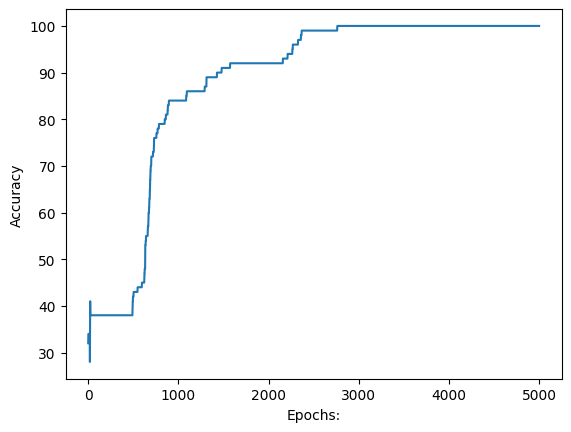

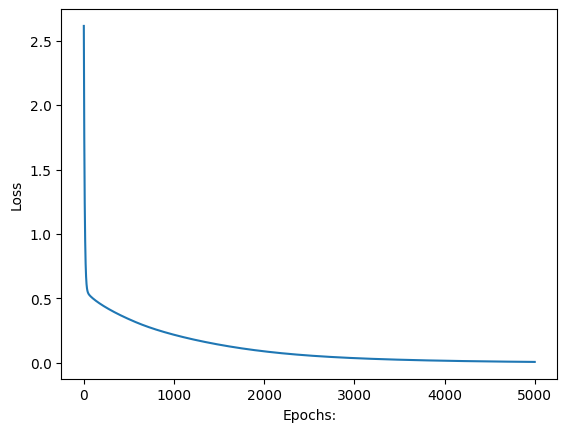

In [8]:
MSE = MeanSquareError()

net3 = NeuralNet([
    Linear(input_size=12, output_size=4),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=6, output_size=6),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=4, output_size=1),
])

train(net3, inputs=dataset.values, targets=labels.values, loss=MSE)